# Normalizing flows: binary classification

## Load packages

In [1]:
using Random
using LinearAlgebra
using PyPlot
using Distributions
using BenchmarkTools
using ProgressMeter
using Optim
using Revise

using ReactiveMP
using GraphPPL
using Rocket;

## Generate data

In [2]:
function generate_data(nr_samples::Int64)

    # sample weights
    w = rand(nr_samples,2)

    # sample appraisal
    y = zeros(Float64, nr_samples)
    for k = 1:nr_samples
        y[k] = 1.0*(w[k,1] > 0.5)*(w[k,2] < 0.5)
    end

    # return data
    return y, w

end;

In [3]:
data_y, data_x = generate_data(200);

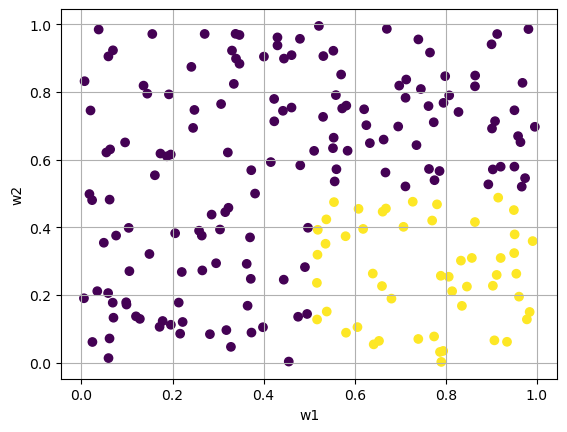

In [4]:
plt.scatter(data_x[:,1], data_x[:,2], c=data_y)
plt.grid()
plt.xlabel("w1")
plt.ylabel("w2");

## Model specification

In [5]:
# specify flow model
model = FlowModel(2,
    (
        AdditiveCouplingLayer(PlanarFlow()), # defaults to AdditiveCouplingLayer(PlanarFlow(); permute=true)
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow())
    )
)   

FlowModel{8,Tuple{ReactiveMP.AdditiveCouplingLayerEmpty{ReactiveMP.PlanarFlowEmpty{1}},PermutationLayer{Int64},ReactiveMP.AdditiveCouplingLayerEmpty{ReactiveMP.PlanarFlowEmpty{1}},PermutationLayer{Int64},ReactiveMP.AdditiveCouplingLayerEmpty{ReactiveMP.PlanarFlowEmpty{1}},PermutationLayer{Int64},ReactiveMP.AdditiveCouplingLayerEmpty{ReactiveMP.PlanarFlowEmpty{1}},PermutationLayer{Int64}}}(2, (ReactiveMP.AdditiveCouplingLayerEmpty{ReactiveMP.PlanarFlowEmpty{1}}(2, ReactiveMP.PlanarFlowEmpty{1}(Val{1}()), 1), PermutationLayer{Int64}(2, [0 1; 1 0]), ReactiveMP.AdditiveCouplingLayerEmpty{ReactiveMP.PlanarFlowEmpty{1}}(2, ReactiveMP.PlanarFlowEmpty{1}(Val{1}()), 1), PermutationLayer{Int64}(2, [0 1; 1 0]), ReactiveMP.AdditiveCouplingLayerEmpty{ReactiveMP.PlanarFlowEmpty{1}}(2, ReactiveMP.PlanarFlowEmpty{1}(Val{1}()), 1), PermutationLayer{Int64}(2, [0 1; 1 0]), ReactiveMP.AdditiveCouplingLayerEmpty{ReactiveMP.PlanarFlowEmpty{1}}(2, ReactiveMP.PlanarFlowEmpty{1}(Val{1}()), 1), PermutationLayer

In [6]:
@model function flow_classifier(nr_samples::Int64, model::FlowModel, params)
    
    # initialize variables
    x_lat  = randomvar(nr_samples)
    y_lat1 = randomvar(nr_samples)
    y_lat2 = randomvar(nr_samples)
    y      = datavar(Float64, nr_samples)
    x      = datavar(Vector{Float64}, nr_samples)

    # compile flow model
    meta  = FlowMeta(compile(model, params)) # default: FlowMeta(model, Linearization())

    # specify observations
    for k = 1:nr_samples

        # specify latent state
        x_lat[k] ~ MvNormalMeanPrecision(x[k], 1e3*diagm(ones(2)))

        # specify transformed latent value
        y_lat1[k] ~ Flow(x_lat[k]) where { meta = meta }
        y_lat2[k] ~ dot(y_lat1[k], [1, 1])

        # specify observations
        y[k] ~ Probit(y_lat2[k]) # default: where { pipeline = RequireInbound(in = NormalMeanPrecision(0, 1.0)) }

    end

    # return variables
    return x_lat, x, y_lat1, y_lat2, y

end;

## Probabilistic Inference

In [7]:
function inference_flow_classifier(data_y::Array{Float64,1}, data_x::Array{Array{Float64,1},1}, model::FlowModel, params)
    
    # fetch number of samples
    nr_samples = length(data_y)

    # define model
    model, (x_lat, x, y_lat1, y_lat2, y) = flow_classifier(nr_samples, model, params)

    # initialize free energy
    fe_buffer = nothing
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (fe) -> fe_buffer = fe)

    # update y and x according to observations (i.e. perform inference)
    ReactiveMP.update!(y, data_y)
    ReactiveMP.update!(x, data_x)

    # unsubscribe
    unsubscribe!(fe_sub)
    
    # return the marginal values
    return fe_buffer

end;

In [8]:
function f(params)
    fe = inference_flow_classifier(data_y, [data_x[k,:] for k=1:size(data_x,1)], model, params)
    return fe
end;

## Experimental validation

In [9]:
res = optimize(f, randn(nr_params(model)), LBFGS(), Optim.Options(store_trace = true, show_trace = true), autodiff=:forward)

Iter     Function value   Gradient norm 
     0     2.358393e+03     1.081236e+03
 * time: 0.007999897003173828
     1     4.572205e+02     6.060750e+02
 * time: 1.3959999084472656
     2     2.649889e+02     9.037034e+01
 * time: 1.5850000381469727
     3     2.609385e+02     4.076189e+01
 * time: 1.7179999351501465
     4     1.973154e+02     8.505047e+01
 * time: 2.180999994277954
     5     1.930187e+02     1.017663e+02
 * time: 2.3320000171661377
     6     1.364556e+02     2.214780e+02
 * time: 2.5859999656677246
     7     6.083997e+01     9.067121e+01
 * time: 2.8339998722076416
     8     4.786869e+01     6.304845e+01
 * time: 3.062000036239624
     9     3.986358e+01     5.705541e+01
 * time: 3.1989998817443848
    10     3.668039e+01     1.638083e+01
 * time: 3.3289999961853027
    11     3.376274e+01     3.480187e+01
 * time: 3.5789999961853027
    12     3.118318e+01     1.714583e+01
 * time: 3.794999837875366
    13     3.049229e+01     2.197325e+01
 * time: 3.92799997329

 * Status: success

 * Candidate solution
    Final objective value:     1.318725e+00

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 6.31e+02 ≰ 1.0e-08

 * Work counters
    Seconds run:   44  (vs limit Inf)
    Iterations:    179
    f(x) calls:    732
    ∇f(x) calls:   732


In [10]:
function uniformpdf(y; xmin = 0, xmax = 1, ymin = 0, ymax = 1)
    indomain = 1.0*(xmin <= y[1] <= xmax)*(ymin <= y[2] <= ymax)
    return indomain/(xmax-xmin)/(ymax-ymin)
end

uniformpdf (generic function with 1 method)

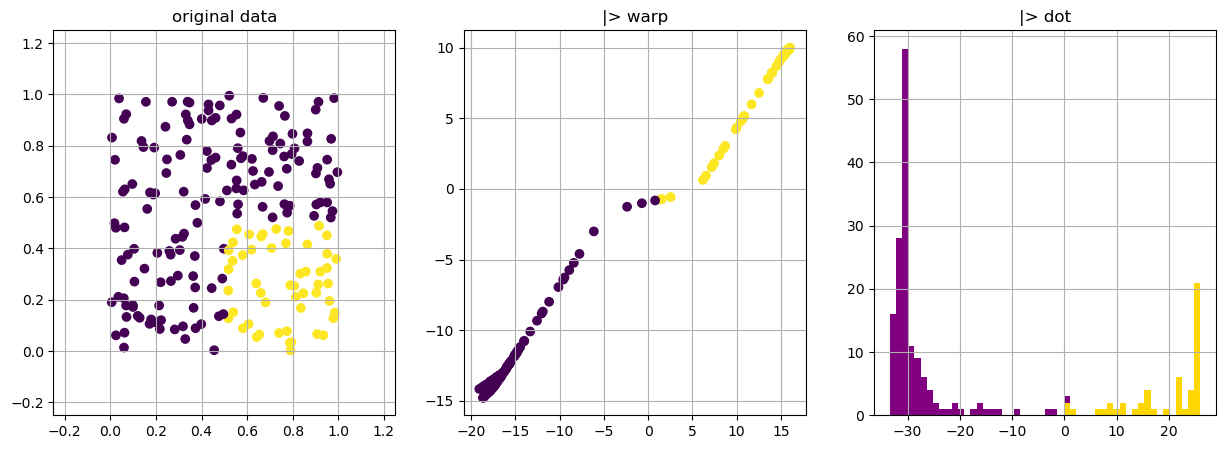

In [11]:
params = Optim.minimizer(res)
inferred_model = compile(model, params)
trans_data_x_1 = hcat(map((x) -> forward(inferred_model, x), [data_x[k,:] for k=1:size(data_x,1)])...)'
trans_data_x_2 = map((x) -> dot([1, 1], x), [trans_data_x_1[k,:] for k=1:size(data_x,1)])
trans_data_x_2_split = [trans_data_x_2[data_y .== 1.0], trans_data_x_2[data_y .== 0.0]]
fig, ax = plt.subplots(ncols = 3, figsize=(15,5))
ax[1].scatter(data_x[:,1], data_x[:,2], c = data_y)
ax[2].scatter(trans_data_x_1[:,1], trans_data_x_1[:,2], c = data_y)
ax[3].hist(trans_data_x_2_split; stacked=true, bins=50, color = ["gold", "purple"])
ax[1].grid(), ax[2].grid(), ax[3].grid()
ax[1].set_xlim(-0.25,1.25), ax[1].set_ylim(-0.25,1.25)
ax[1].set_title("original data"), ax[2].set_title("|> warp"), ax[3].set_title("|> dot");

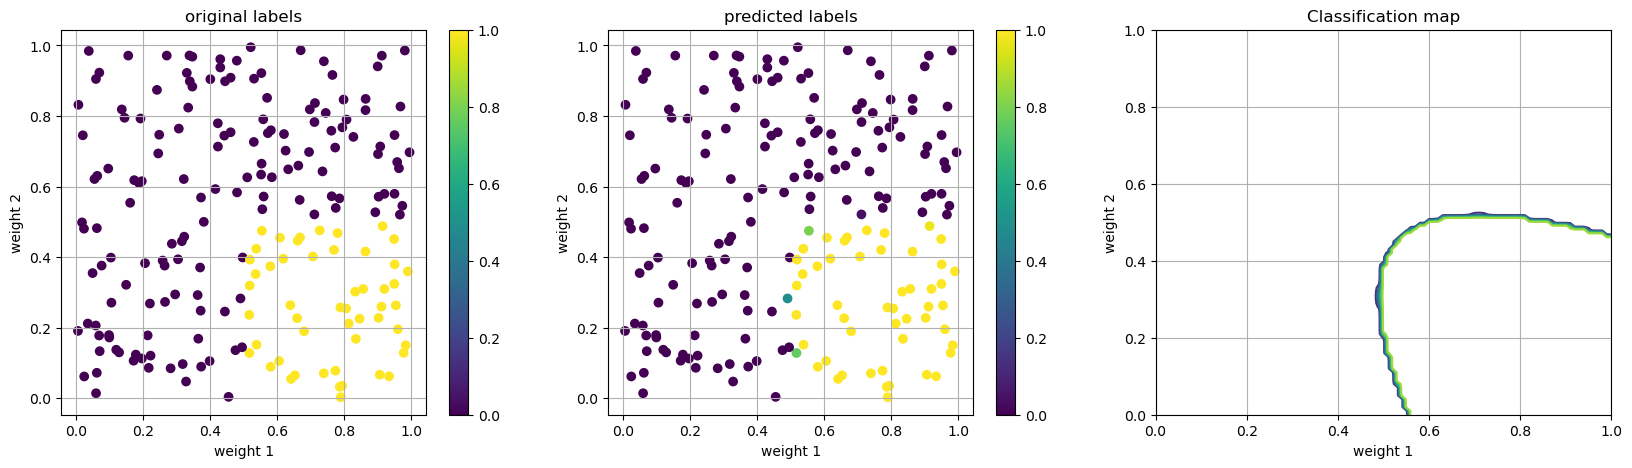

In [12]:
using StatsFuns: normcdf
classification_map = map((x) -> normcdf(dot([1,1],x)), map((x) -> forward(inferred_model, [x...]), collect(Iterators.product(0:0.01:1, 0:0.01:1))))
fig, ax = plt.subplots(ncols = 3, figsize=(20,5))
im1 = ax[1].scatter(data_x[:,1], data_x[:,2], c = data_y)
im2 = ax[2].scatter(data_x[:,1], data_x[:,2], c = normcdf.(trans_data_x_2))
ax[3].contour(repeat(0:0.01:1, 1, 101), repeat(0:0.01:1, 1, 101)', classification_map)
plt.colorbar(im1, ax=ax[1])
plt.colorbar(im2, ax=ax[2])
ax[1].grid(), ax[2].grid(), ax[3].grid()
ax[1].set_xlabel("weight 1"), ax[1].set_ylabel("weight 2"), ax[2].set_xlabel("weight 1"), ax[2].set_ylabel("weight 2"), ax[3].set_xlabel("weight 1"), ax[3].set_ylabel("weight 2")
ax[1].set_title("original labels"), ax[2].set_title("predicted labels"), ax[3].set_title("Classification map");

In [13]:
params_comparison = [   -16.971881527516572
                        1.6906882449748233
                        9.58620537310562
                        14.41799007763637
                        -0.6356073743299993
                        -8.584499681932611
                        11.320057543140475
                        3.0874286057733142
                        6.461029274995887
                        45.81004120933731
                        -7.228339234945879
                        -41.09968671707267]
f(params_comparison)

6.846880787190912